# P2

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import cv2
import os
from google.colab import files

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [2]:
# @title Download Dataset from Kaggle (A kaggle.json should be downloaded by your Kaggle's account)
print('Upload kaggle.json account information to download the dataset:')
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d  paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip

Upload kaggle.json account information to download the dataset:


Saving kaggle.json to kaggle.json
100% 2.29G/2.29G [01:00<00:00, 38.9MB/s]
100% 2.29G/2.29G [01:00<00:00, 40.7MB/s]


In [3]:
base_directory = '/content/chest_xray/'

# Define sub-directories for training, validation, and testing data
sub_directories = ['train/', 'val/', 'test/']

# Get a list of classes (sub-directories) inside the 'train/' directory
classes = os.listdir(
    os.path.join(base_directory, sub_directories[0])
)

print(classes)

['NORMAL', 'PNEUMONIA']


In [4]:
X = []
y = []

# Loop through the sub-directories (train, val, test)
for sub_dir in sub_directories:
    for c in range(len(classes)):
        dir = os.path.join(base_directory, sub_dir, classes[c])

        # Loop through files in the class directory
        for f in os.listdir(dir):
            img = cv2.imread(os.path.join(dir, f))
            img = cv2.resize(img, (128, 128))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            X.append(img)
            y.append(c)


# Convert lists to numpy arrays and normalize pixel values
X = np.asarray(X) / 255.0
y = np.asarray(y)

X.shape

(5856, 128, 128, 3)

In [5]:
# Perform a stratified shuffle split to create a train-test split with 60% training data
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=0)
train_index, test_index = next(splitter.split(X, y))

X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]

# Perform another stratified shuffle split on the test set to create a test-validation split with 50% test data
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
test_index, val_index = next(splitter.split(X_test, y_test))

X_test, X_val = X_test[test_index], X_test[val_index]
y_test, y_val = y_test[test_index], y_test[val_index]

In [6]:
print(f'\t\t{classes[0]}\t\t{classes[1]}')
print(f'training:\t{np.count_nonzero(y_train==0)}\t\t{np.count_nonzero(y_train==1)}')
print(f'validation:\t{np.count_nonzero(y_val==0)}\t\t{np.count_nonzero(y_val==1)}')
print(f'testing:\t{np.count_nonzero(y_test==0)}\t\t{np.count_nonzero(y_test==1)}')

		NORMAL		PNEUMONIA
training:	950		2563
validation:	317		855
testing:	316		855


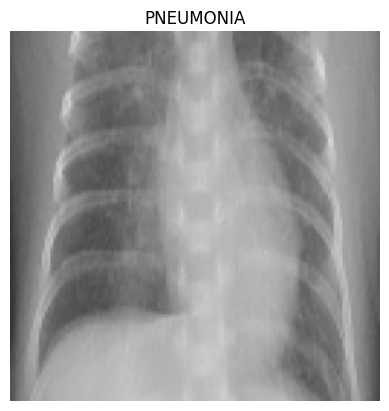

In [7]:
plt.imshow(X_train[0])
plt.title(classes[y_train[0]])
plt.axis("Off");
plt.show()

In [8]:
generator = ImageDataGenerator(
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=30,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='constant',
    cval=0.0
)

batch_size = 32

# Calculate the number of steps per epoch
steps_per_epoch = X_train.shape[0] // batch_size

data_iterator = generator.flow(X_train, y_train, batch_size=batch_size)

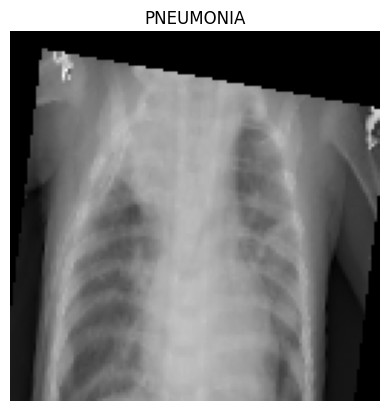

In [9]:
img, label = generator.flow(X_train, y_train, batch_size=1).next()

plt.imshow(img[0])
plt.title(classes[label[0]])
plt.axis("Off");
plt.show()

In [10]:
# Calculate class weights using 'balanced' mode
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)

# Create a dictionary mapping class indices to their respective weights
class_weight = {
    0: class_weights[0],
    1: class_weights[1]
}

In [11]:
# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',   # Monitor validation accuracy
    patience=5,               # Allow training to continue for 5 epochs without improvement
    verbose=1,                # Print messages about early stopping
    restore_best_weights=True # Restore model weights to the best epoch
)

# Model checkpoint callback
checkpoints = ModelCheckpoint(
    'tmp/checkpoint',        # Save the model checkpoints to the specified directory
    monitor='val_accuracy',   # Monitor validation accuracy
    save_best_only=True,      # Save only the best model
    verbose=1                 # Print messages about model checkpoints
)


In [12]:
# Define the input layer with shape (128, 128, 3)
input_layer = keras.layers.Input(shape=(128, 128, 3))

# Load pre-trained EfficientNetB2 model without top layer
efficientNet = keras.applications.EfficientNetB2(
    include_top=False, weights="imagenet", input_shape=(128, 128, 3))

x = efficientNet(input_layer, training=True)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(input_layer, output_layer)

31790344/31790344 [==============================] - 1s 0us/step


In [13]:
# Freeze the layers in the EfficientNet model up to the 74th layer
for layer in efficientNet.layers[:74]:
    layer.trainable = False

# Define a learning rate schedule using Piecewise Constant Decay
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    [10*steps_per_epoch, 15*steps_per_epoch],  # At 10 and 15 epochs (in steps)
    [0.00001, 0.000005, 0.000001]  # Learning rates at those points
)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    data_iterator,
    epochs = 20,
    class_weight = class_weight,
    steps_per_epoch = steps_per_epoch,
    validation_data = (X_val, y_val),
    callbacks = [early_stopping, checkpoints]
)

Epoch 1/20
109/109 [==============================] - ETA: 0s - loss: 0.6797 - accuracy: 0.5381
Epoch 1: val_accuracy improved from -inf to 0.67491, saving model to tmp/checkpoint
109/109 [==============================] - 127s 667ms/step - loss: 0.6797 - accuracy: 0.5381 - val_loss: 0.6327 - val_accuracy: 0.6749
Epoch 2/20
109/109 [==============================] - ETA: 0s - loss: 0.6164 - accuracy: 0.6286
Epoch 2: val_accuracy improved from 0.67491 to 0.71843, saving model to tmp/checkpoint
109/109 [==============================] - 67s 619ms/step - loss: 0.6164 - accuracy: 0.6286 - val_loss: 0.5739 - val_accuracy: 0.7184
Epoch 3/20
109/109 [==============================] - ETA: 0s - loss: 0.5656 - accuracy: 0.6903
Epoch 3: val_accuracy improved from 0.71843 to 0.76877, saving model to tmp/checkpoint
109/109 [==============================] - 68s 624ms/step - loss: 0.5656 - accuracy: 0.6903 - val_loss: 0.5255 - val_accuracy: 0.7688
Epoch 4/20
109/109 [==============================]

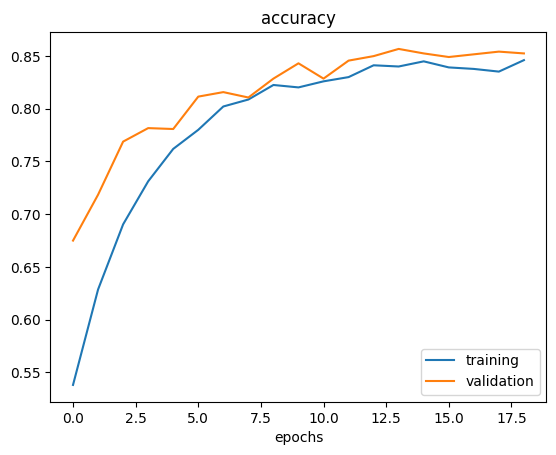

In [14]:
plt.plot(history.history['accuracy'], label="training")
plt.plot(history.history['val_accuracy'], label="validation")
plt.title('accuracy')
plt.xlabel("epochs")
plt.legend(loc='lower right')
plt.show()

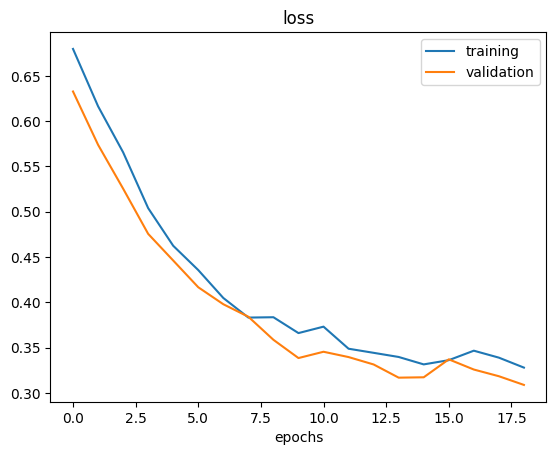

In [15]:
plt.plot(history.history['loss'], label="training")
plt.plot(history.history['val_loss'], label="validation")
plt.title('loss')
plt.xlabel("epochs")
plt.legend()
plt.show()

In [16]:
# Obtain predicted probabilities for the test set
probas = model.predict(X_test)

# Convert probabilities to binary predictions using a threshold of 0.5
y_pred = np.asarray(0.5 < probas, dtype=np.int32)

37/37 [==============================] - 5s 42ms/step


In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.91      0.77       316
           1       0.96      0.83      0.89       855

    accuracy                           0.85      1171
   macro avg       0.82      0.87      0.83      1171
weighted avg       0.88      0.85      0.86      1171



In [18]:
def draw_confusion_matrix(matrix):
    green = (30, 200, 40, 160)
    red = (255, 25, 0, 140)

    x = matrix.shape[1]
    y = matrix.shape[0]

    colors = [[green if i==j else red for i in range(x)] for j in range(y)]
    colors = np.array(colors).astype(np.uint8)

    fig, ax = plt.subplots(figsize=(4, 4), dpi=90)
    ax.imshow(colors)

    ax.set_xticks(np.arange(x), labels=range(x))
    ax.set_yticks(np.arange(y), labels=range(y))

    ax.set_xticks(np.arange(-.5, x, 1), minor=True)
    ax.set_yticks(np.arange(-.5, y, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
    ax.tick_params(which='minor', bottom=False, left=False)

    ax.set_xlabel("prediction")
    ax.set_ylabel("label")

    for i in range(y):
        for j in range(x):
            text = ax.text(j, i, matrix[i][j], ha="center", va="center", color='black')

    ax.set_title("Confusion Matrix")
    fig.tight_layout()
    plt.show()

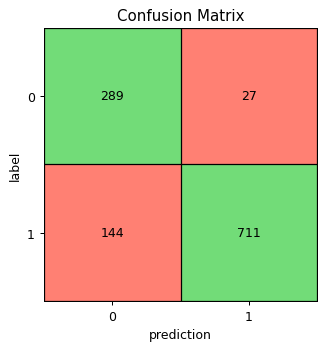

In [19]:
draw_confusion_matrix(
    confusion_matrix(y_test, y_pred)
)

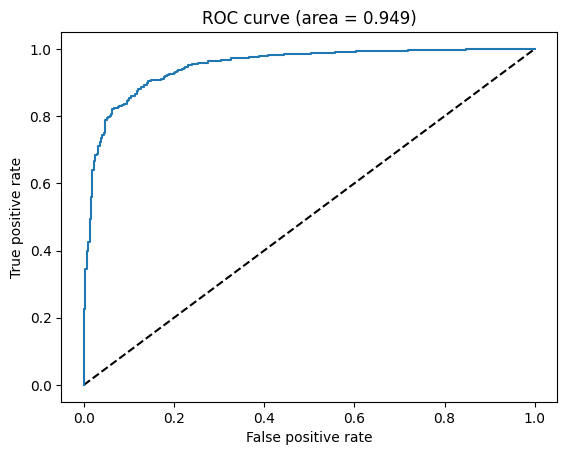

In [20]:
# Calculate the False Positive Rate (FPR), True Positive Rate (TPR), and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, probas.ravel())

# Calculate the Area Under the Curve (AUC)
area_under_curve = auc(fpr, tpr)

# Plot the ROC curve
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random chance
plt.plot(fpr, tpr)  # Plot the actual ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve (area = {:.3f})'.format(area_under_curve))
plt.show()